# Process the Downloaded DWD Time Series with Pandas and Prepare for QGIS TimeManager

## Steps to be performed

1. Process the DWD station data. It gives you **lat, lon**.
1. Extract the time series data from the downloadwd zip archives.
1. Determine the temperature difference with respect to a reference temperature.
1. **Merge** the TS data into Pandas _side by side_, i.e. the columns of the dataframe are time series.
1. **Append** the time series of all stations _one after the other_.
1. **Merge** this long dataframe with the station data to add the columns lat, lon.
1. Save it as CSV and import it to QGIS. 
1. Use the TimaManager plugin to generate maps for each time step and export the maps as png. 
1. Make a movie.


### The Final Dataframe Format

Create a dataframe with the following structure:

| station_id |  timestamp | temp_diff |  lat | lon |
|-----------:|-----------:|-----------:|-----:|----:|
|          1 | 1980-01-01 |       2.3 | 51.2 | 7.0 |
|          1 | 1981-01-01 |       1.3 | 51.2 | 7.0 |
|          1 | 1982-01-01 |       1.7 | 51.2 | 7.0 |
|        ... |        ... |        ... |  ... | ... |
|         10 | 1980-01-01 |       3.5 | 50.7 | 6.5 |
|         10 | 1981-01-01 |       2.7 | 50.7 | 6.5 |
|         10 | 1982-01-01 |       3.1 | 50.7 | 6.5 |
|        ... |        ... |        ... |  ... | ... |

Save it as a CSV file and import it to QGIS.

## Local Directory Storing the Downloaded FTP Archives

In [5]:
localdir = "data/DWD/annual/kl/historical/"

## Select zip files only

In [6]:
import pathlib
p = pathlib.Path(localdir)

# create a list of all Path objects of the zip files
ziplist = [elt for elt in p.iterdir() if elt.suffix == ".zip"]
print("** You should see a list of Path objects pointing to the zip files, e.g. WindowsPath or PosixPath **")
print()
print(ziplist)

** You should see a list of Path objects pointing to the zip files, e.g. WindowsPath or PosixPath **

[WindowsPath('data/DWD/annual/kl/historical/jahreswerte_KL_01078_19400101_20191231_hist.zip'), WindowsPath('data/DWD/annual/kl/historical/jahreswerte_KL_01300_19310101_20191231_hist.zip'), WindowsPath('data/DWD/annual/kl/historical/jahreswerte_KL_01303_18880101_20191231_hist.zip'), WindowsPath('data/DWD/annual/kl/historical/jahreswerte_KL_01327_19370101_20191231_hist.zip'), WindowsPath('data/DWD/annual/kl/historical/jahreswerte_KL_01590_19370101_20191231_hist.zip'), WindowsPath('data/DWD/annual/kl/historical/jahreswerte_KL_02110_19380101_20191231_hist.zip'), WindowsPath('data/DWD/annual/kl/historical/jahreswerte_KL_02483_19290101_20191231_hist.zip'), WindowsPath('data/DWD/annual/kl/historical/jahreswerte_KL_02497_19370101_20191231_hist.zip'), WindowsPath('data/DWD/annual/kl/historical/jahreswerte_KL_02629_18510101_20191231_hist.zip'), WindowsPath('data/DWD/annual/kl/historical/jahreswe

## Extract only the needed KL product files and merge them to Pandas dataframe.

In [7]:
import pandas as pd
from zipfile import ZipFile

# Very compact code.
df = pd.DataFrame()
for elt in ziplist:
    with ZipFile(elt) as myzip:
        
        # read the time series data from the file starting with "produkt"
        prodfilename = [name for name in myzip.namelist() if name.split("_")[0]=="produkt"][0] 
        #print(prodfilename)
        
        # open just the produkt file within the archive
        with myzip.open(prodfilename) as myfile:
            dftmp = pd.read_csv(myfile, sep =";", parse_dates = ["MESS_DATUM_BEGINN", "MESS_DATUM_ENDE"], index_col = "MESS_DATUM_BEGINN", na_values = [-999.0])
            # select the series with the average annual temp ("JA_TT"), rename the series with the station_id and make it a df.
            s = dftmp["JA_TT"].rename(dftmp["STATIONS_ID"][0]).to_frame()
            # outer merge.
            df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

#df.index.names = ["year"]
df.index.rename(name = "year", inplace = True)
df.head()

,1078,1300,1303,1327,1590,2110,2483,2497,2629,2968,4063,4371,5717
year,,,,,,,,,,,,,
1851-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.73,NaN,NaN,NaN,NaN
1852-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.90,NaN,NaN,NaN,NaN
1853-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.89,NaN,NaN,NaN,NaN
1854-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.09,NaN,NaN,NaN,NaN
1855-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.34,NaN,NaN,NaN,NaN


## Determine the temperature difference time series relative to a reference temperature.

### Reference temperature: Mean temperature between 1960 and 1990

In [8]:
idx = (df.index <= pd.Timestamp('1990')) & (df.index >= pd.Timestamp('1960'))

In [9]:
temp_mean = df.loc[idx].mean()
temp_mean

1078    10.387143
1300     7.487419
1303     9.568710
1327     9.635484
1590     9.912222
2110     9.807143
2483     4.848065
2497     7.276667
2629     9.628065
2968    10.777419
4063     9.013548
4371     9.241613
5717     9.340000
dtype: float64

In [10]:
# Temperature Difference Time Series dataframe
df_temp_diff = df - temp_mean # broadcast operation
df_temp_diff.tail()

,1078,1300,1303,1327,1590,2110,2483,2497,2629,2968,4063,4371,5717
year,,,,,,,,,,,,,
2015-01-01,0.942857,NaN,1.35129,1.424516,1.187778,1.492857,1.511935,1.563333,1.121935,1.132581,1.386452,1.118387,1.28
2016-01-01,0.772857,1.062581,1.20129,1.224516,1.037778,1.242857,1.311935,1.323333,0.961935,0.862581,1.156452,0.888387,1.07
2017-01-01,1.042857,1.172581,1.35129,1.504516,1.267778,1.582857,1.411935,1.593333,NaN,1.142581,1.316452,0.978387,1.32
2018-01-01,1.732857,1.752581,2.22129,1.964516,1.947778,2.042857,2.411935,2.213333,NaN,1.892581,2.056452,1.808387,NaN
2019-01-01,1.452857,1.522581,1.87129,1.604516,1.707778,1.612857,2.151935,1.993333,1.541935,1.522581,1.936452,1.648387,1.65


### Transpose matrix, plot the rotated heatmap to explore the data coverage.

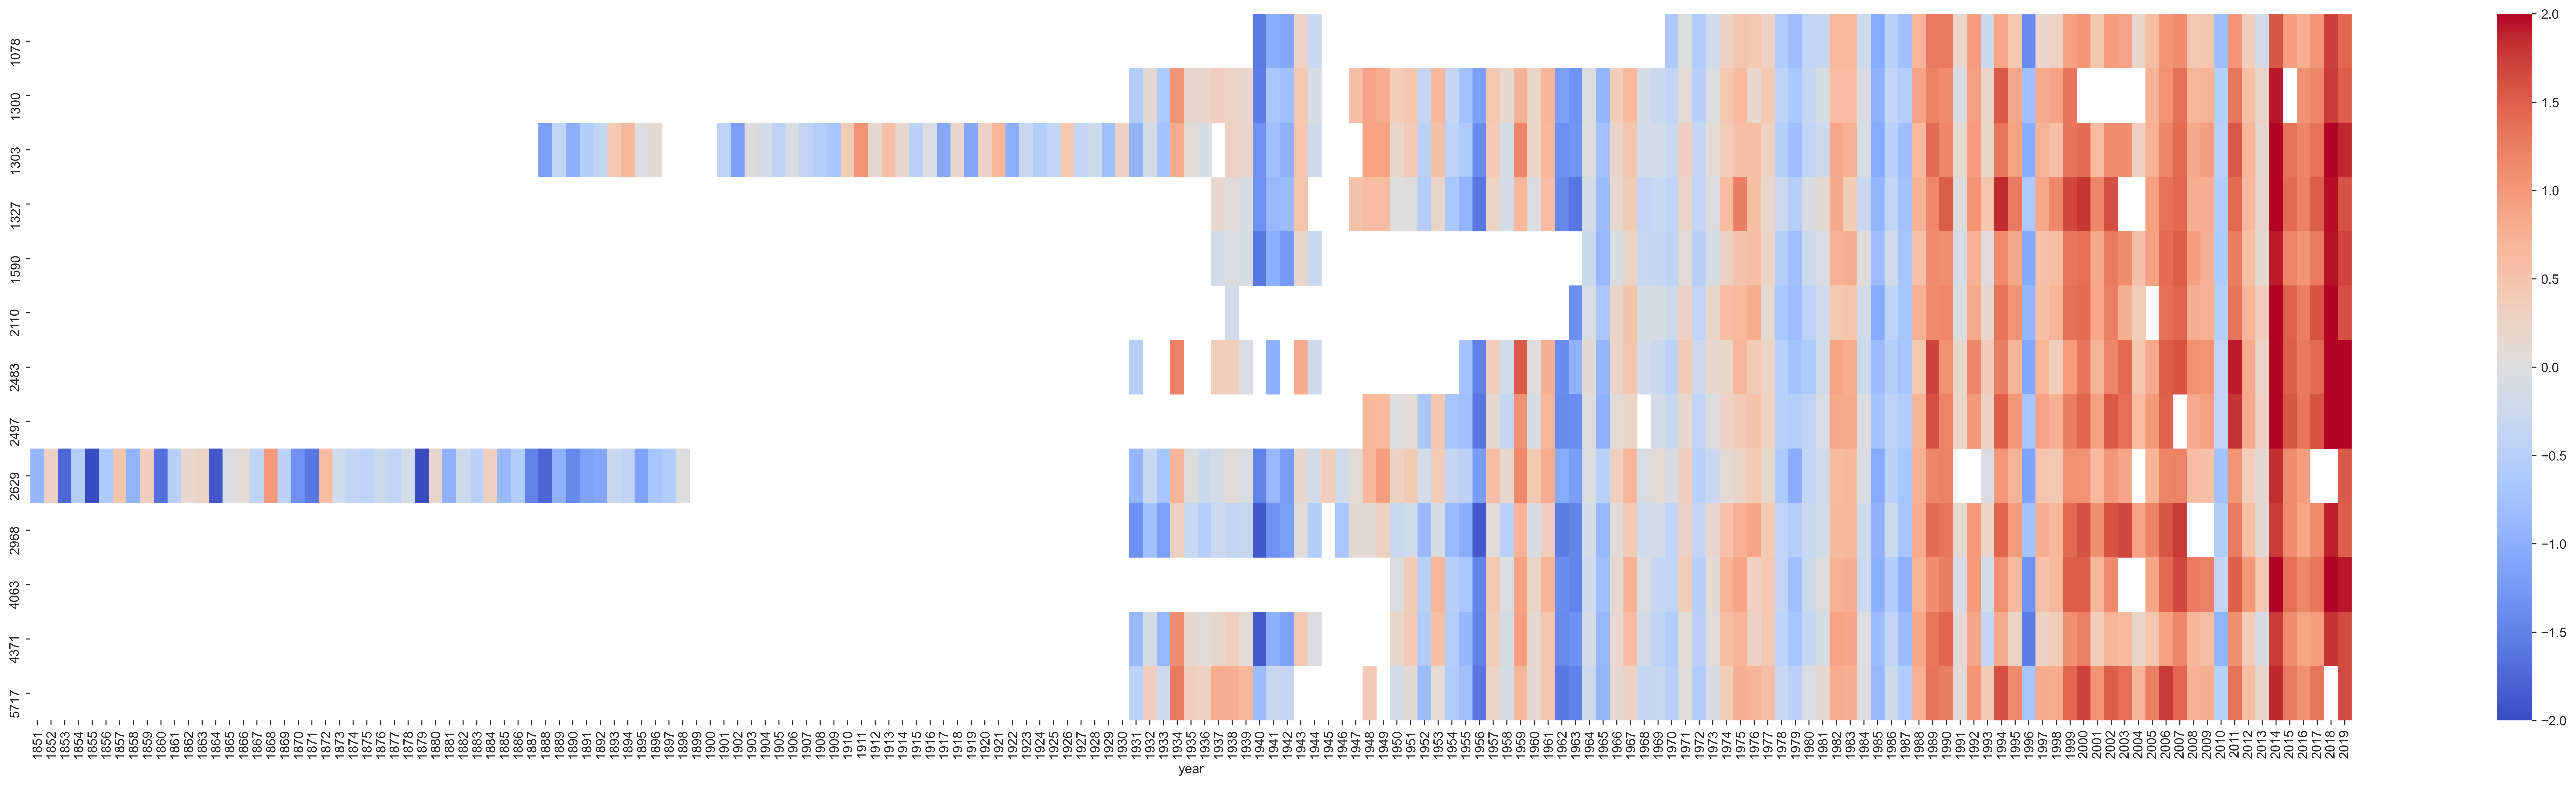

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# plot
sns.set_style('ticks')
fig4, ax4 = plt.subplots(dpi = 400, figsize = (40,10))

#sns.heatmap(df_tdiff, cmap='coolwarm', annot=True, vmin = -2, vmax = 2, ax = ax3)
sns.heatmap(df_temp_diff.T, cmap='coolwarm', vmin = -2, vmax = 2, ax = ax4)
ax4.set_xticklabels(df.index.strftime('%Y'))

plt.show()

fig4.savefig('example4.png')

### Limit the data to years > 1930.

Only two stations of the active ones began to measure before 1931. Nevertheless **important information** is contained in the very old data. Station 2629 having started shows relatively cold years between 1851 and 1898.

Anyway, we will limit the following analysis to years after 1930.

In [44]:
idx = df_temp_diff.index > "1930"
df2 = df_temp_diff.loc[idx].copy()
df2

,1078,1300,1303,1327,1590,2110,2483,2497,2629,2968,4063,4371,5717
year,,,,,,,,,,,,,
1931-01-01,NaN,-0.567419,-0.93871,NaN,NaN,NaN,-0.488065,NaN,-0.908065,-1.347419,NaN,-0.871613,-0.46
1932-01-01,NaN,0.122581,-0.12871,NaN,NaN,NaN,NaN,NaN,-0.298065,-0.767419,NaN,-0.121613,0.34
1933-01-01,NaN,-0.637419,-0.72871,NaN,NaN,NaN,NaN,NaN,-0.688065,-1.177419,NaN,-0.881613,-0.22
1934-01-01,NaN,1.072581,0.81129,NaN,NaN,NaN,1.221935,NaN,0.711935,0.302581,NaN,1.118387,1.28
1935-01-01,NaN,0.182581,0.07129,NaN,NaN,NaN,NaN,NaN,0.021935,-0.287419,NaN,0.158387,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-01,0.942857,NaN,1.35129,1.424516,1.187778,1.492857,1.511935,1.563333,1.121935,1.132581,1.386452,1.118387,1.28
2016-01-01,0.772857,1.062581,1.20129,1.224516,1.037778,1.242857,1.311935,1.323333,0.961935,0.862581,1.156452,0.888387,1.07
2017-01-01,1.042857,1.172581,1.35129,1.504516,1.267778,1.582857,1.411935,1.593333,NaN,1.142581,1.316452,0.978387,1.32


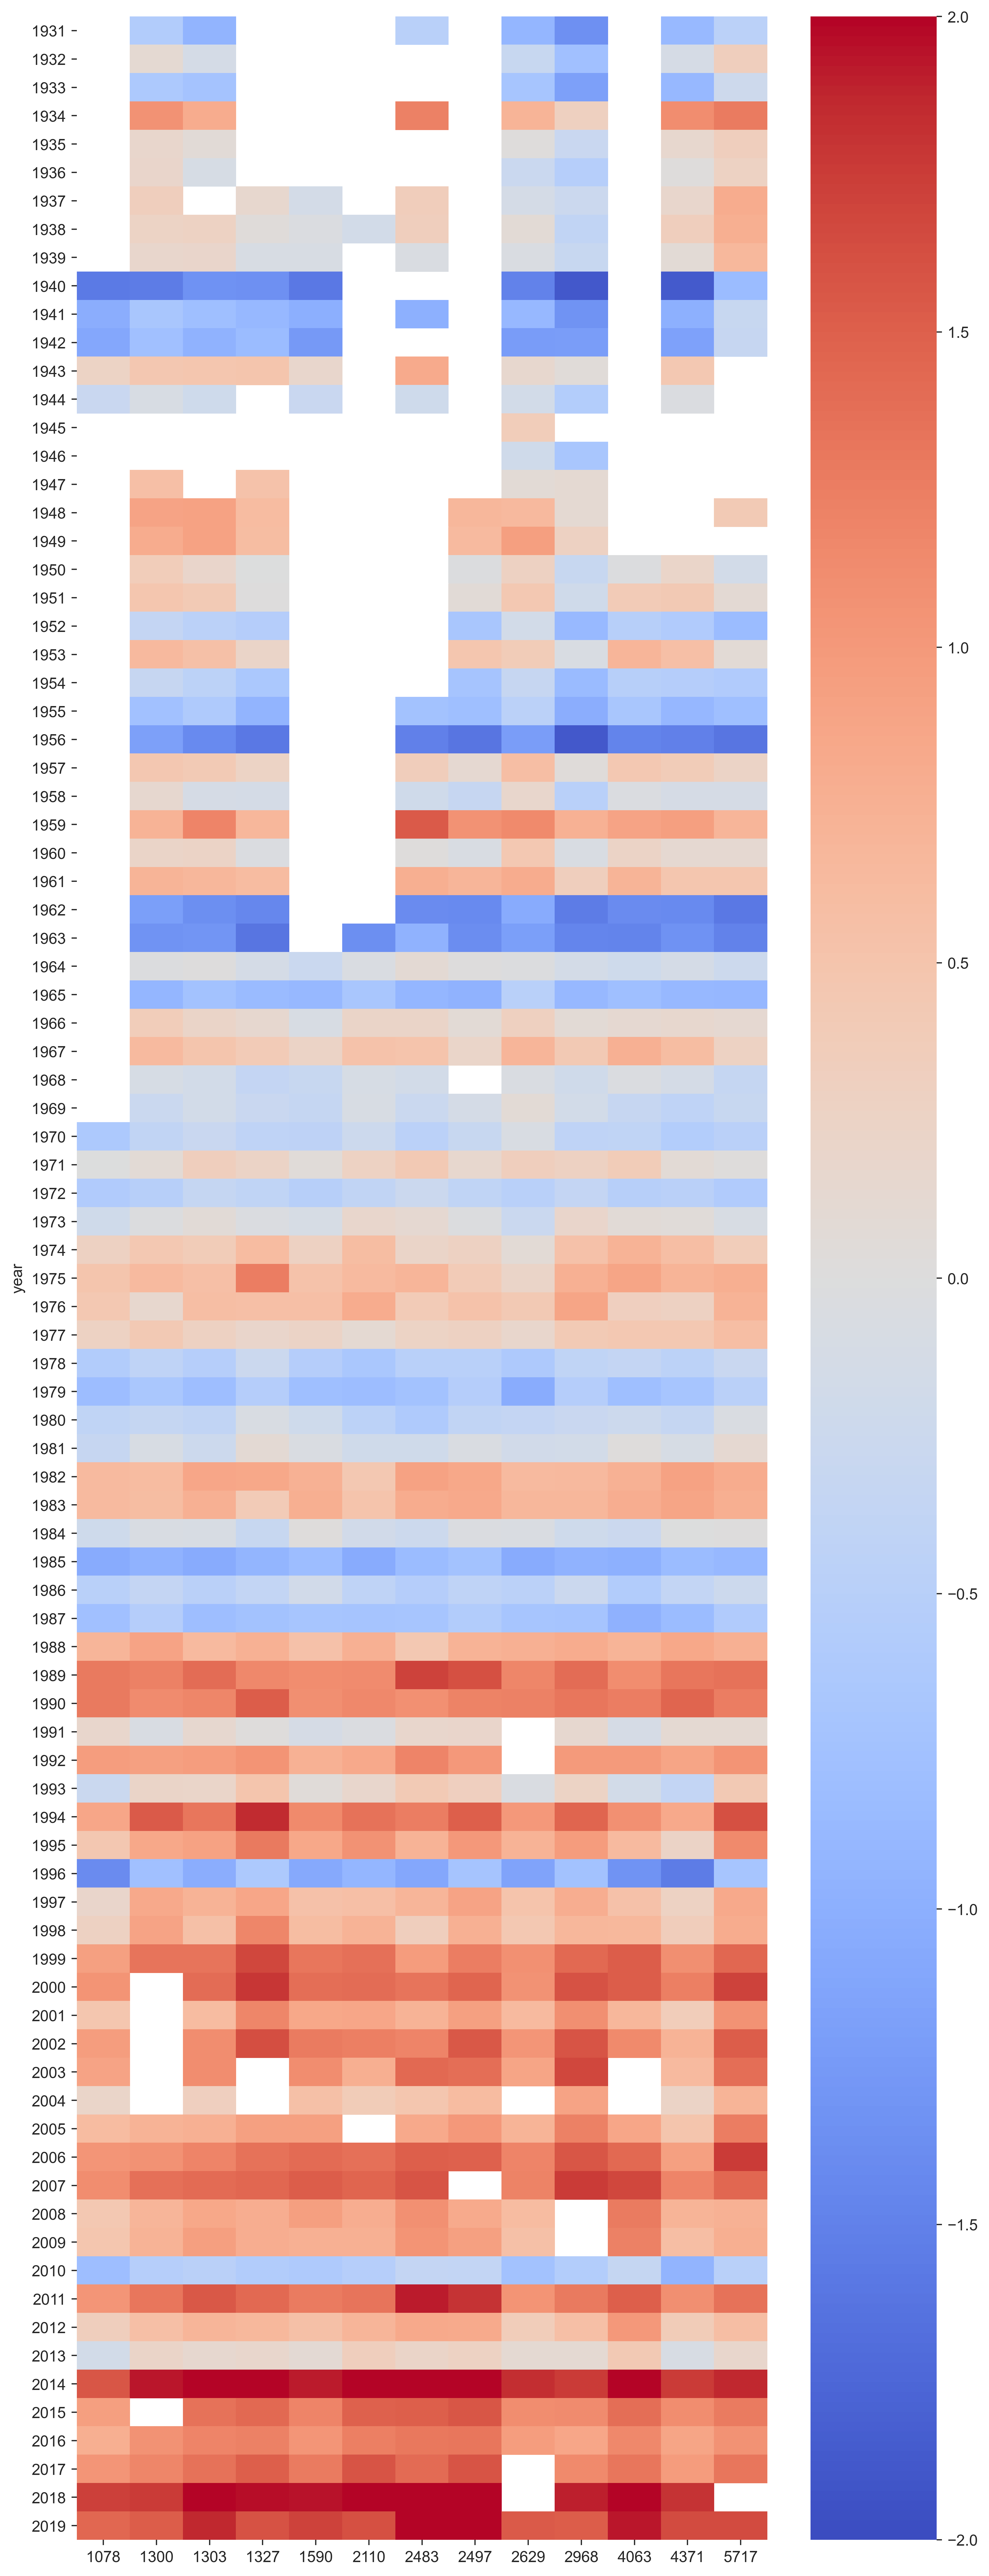

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# plot
sns.set_style('ticks')
fig5, ax5 = plt.subplots(dpi = 400, figsize = (10,30))

#sns.heatmap(df_tdiff, cmap='coolwarm', annot=True, vmin = -2, vmax = 2, ax = ax3)
sns.heatmap(df2, cmap='coolwarm', vmin = -2, vmax = 2, ax = ax5)
ax5.set_yticklabels(df2.index.strftime('%Y'))

plt.show()

#fig5.savefig('example5.png')

### Fill data gaps. STILL MISSING!

## Transform the data: Append all columns (series) to a long dataframe.

In [51]:
for col_id in df2:
    print(col_id)

1078
1300
1303
1327
1590
2110
2483
2497
2629
2968
4063
4371
5717


In [57]:
df_ser = df2[1078].to_frame()

In [61]:
ser = df2[1078]

In [65]:
ser

year
1931-01-01         NaN
1932-01-01         NaN
1933-01-01         NaN
1934-01-01         NaN
1935-01-01         NaN
                ...   
2015-01-01    0.942857
2016-01-01    0.772857
2017-01-01    1.042857
2018-01-01    1.732857
2019-01-01    1.452857
Name: 1078, Length: 89, dtype: float64

In [66]:
df_temp_appended = pd.DataFrame()

# loop over column names
for col_id in df2:
    # extract series
    ser = df2[col_id]
    # rename it
    ser.name = "temp_diff"
    # convert it to dataframe
    #df_tmp = pd.DataFrame(ser)
    df_tmp = ser.to_frame()
    # add a column with the station_id
    df_tmp["station_id"] = col_id
    df_temp_appended = df_temp_appended.append(df_tmp)
    
df_temp_appended.reset_index(inplace = True)
#df_temp_appended.set_index(["station_id", "year"])
df_temp_appended

,year,temp_diff,station_id
0,1931-01-01,NaN,1078
1,1932-01-01,NaN,1078
2,1933-01-01,NaN,1078
3,1934-01-01,NaN,1078
4,1935-01-01,NaN,1078
...,...,...,...
1152,2015-01-01,1.28,5717
1153,2016-01-01,1.07,5717
1154,2017-01-01,1.32,5717
1155,2018-01-01,NaN,5717


## Read the station data and join it with the temp data.

In [67]:
df_stations = pd.read_csv("./data/generated/DWD_stations_NRW_long_TS.csv", sep = ";", index_col = 0)
df_stations.head()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
1078,1940-01-01,2018-12-31,37,51.2960,6.7686,Düsseldorf,Nordrhein-Westfalen
1300,1931-01-01,2018-12-31,351,51.2540,8.1565,Eslohe,Nordrhein-Westfalen
1303,1888-01-01,2018-12-31,150,51.4041,6.9677,Essen-Bredeney,Nordrhein-Westfalen
1327,1937-01-01,2018-12-31,147,50.7119,6.7905,Weilerswist-Lommersum,Nordrhein-Westfalen
1590,1937-01-01,2018-12-31,37,51.4942,6.2463,Geldern-Walbeck,Nordrhein-Westfalen


In [73]:
df_temp_TM_ready = df_temp_appended.merge(df_stations[["name","latitude","longitude","altitude"]], how="inner", on = "station_id")
df_temp_TM_ready 

,year,temp_diff,station_id,name,latitude,longitude,altitude
0,1931-01-01,NaN,1078,Düsseldorf,51.2960,6.7686,37
1,1932-01-01,NaN,1078,Düsseldorf,51.2960,6.7686,37
2,1933-01-01,NaN,1078,Düsseldorf,51.2960,6.7686,37
3,1934-01-01,NaN,1078,Düsseldorf,51.2960,6.7686,37
4,1935-01-01,NaN,1078,Düsseldorf,51.2960,6.7686,37
...,...,...,...,...,...,...,...
974,2015-01-01,1.118387,4371,"Salzuflen, Bad",52.1042,8.7521,135
975,2016-01-01,0.888387,4371,"Salzuflen, Bad",52.1042,8.7521,135
976,2017-01-01,0.978387,4371,"Salzuflen, Bad",52.1042,8.7521,135
977,2018-01-01,1.808387,4371,"Salzuflen, Bad",52.1042,8.7521,135


In [74]:
df_temp_TM_ready.to_csv("./data/generated/DWD_NRW_annual_temperatures_TM_ready.csv", sep = ";")